# Comparing the percentage of Students with Disabilities between Charter and Public Schools in Massachusetts

## The Question

In [1]:
# import packages
from scipy.stats import ttest_ind, ttest_ind_from_stats
from statsmodels.stats.proportion import proportions_ztest
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np

# set jupyter netbook options
pd.set_option('max_columns',0)
%matplotlib inline

In [2]:
# read data from Mass DOE
schools = pd.read_csv('MA_Public_Schools_2017.csv')
schools.dropna(inplace=True, subset=['Students With Disabilities'])

# select columns relevant to English Language Learners
school_dis = schools[['School Code','School Name','School Type','District Name','District Code','Zip',
                      'TOTAL_Enrollment', 'Students With Disabilities', '% Students With Disabilities']]

school_dis.head()

,School Code,School Name,School Type,District Name,District Code,Zip,TOTAL_Enrollment,Students With Disabilities,% Students With Disabilities
0,10505,Abington High,Public School,Abington,10000,2351,452,44.0,9.7
1,10003,Beaver Brook Elementary School,Public School,Abington,10000,2351,580,77.0,13.3
2,10002,Center Elementary School,Public School,Abington,10000,2351,203,43.0,21.2
3,10405,Frolio Middle School,Public School,Abington,10000,2351,328,43.0,13.1
4,10015,Woodsdale Elementary School,Public School,Abington,10000,2351,353,38.0,10.8


In [5]:
school_dis.pivot_table(index = 'School Type', 
                       values=['Students With Disabilities', '% Students With Disabilities'],
                       aggfunc={'Students With Disabilities':'sum', '% Students With Disabilities':'mean'})

,% Students With Disabilities,Students With Disabilities
School Type,,
Charter School,15.423077,6078.0
Public School,18.346953,150964.0


In [6]:
charter_dis = schools[schools['School Type'] == 'Charter School']['% Students With Disabilities']
public_dis  = schools[schools['School Type'] == 'Public School']['% Students With Disabilities']

print('Charter mean: {:.2f}  Public mean: {:.2f}'.format(charter_dis.mean(), public_dis.mean()))

ttest_ind(charter_dis, public_dis)

Charter mean: 15.42  Public mean: 18.35


Ttest_indResult(statistic=-2.2071254525129809, pvalue=0.027427811409878777)

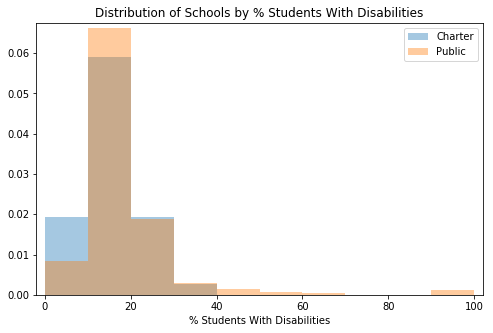

In [7]:
bins = [10*i for i in range(0,11)]

plt.figure(figsize=(8,5))
sns.distplot(charter_dis, bins=bins, kde=False, norm_hist=True)
sns.distplot(public_dis, bins=bins, kde=False, norm_hist=True)
plt.title('Distribution of Schools by % Students With Disabilities')
plt.margins(0.02)
plt.legend(['Charter', 'Public'])

In [10]:
f= {'TOTAL_Enrollment':'sum', 'Students With Disabilities':'sum', '% Students With Disabilities':'mean'}

school_dis_by_zip = school_dis.drop(['School Code', 'School Name', 'District Name', 'District Code'], axis=1).groupby(['Zip', 'School Type']).agg(f)

# slice demographic data by zip codes with public and charter schools
idx = pd.IndexSlice
public_and_charter = [i for i in school_dis['Zip'] if len(school_dis_by_zip.loc[idx[i]]) == 2]
school_dis_compare = school_dis_by_zip.loc[idx[public_and_charter]].copy()

In [11]:
school_dis_compare.head(6)

TOTAL_Enrollment              ...               % Students With Disabilities
Zip  School Type                                   ...                                           
1022 Charter School               478              ...                                   7.700000
     Public School                366              ...                                  10.700000
1027 Charter School               218              ...                                  16.500000
     Public School               2433              ...                                  19.014286
1035 Charter School               471              ...                                   5.900000
     Public School                562              ...                                  11.800000

[6 rows x 3 columns]

In [12]:
def compare_dis(i):        
    '''Return the p-value of a two-sample proportion z-test between samples of students with disabilities.'''
    count_1 = school_dis_by_zip.loc[idx[i[0]]].iloc[0].loc['Students With Disabilities']
    count_2 = school_dis_by_zip.loc[idx[i[0]]].iloc[1].loc['Students With Disabilities']
    
    obs_1 = school_dis_by_zip.loc[idx[i[0]]].iloc[0].loc['TOTAL_Enrollment']
    obs_2 = school_dis_by_zip.loc[idx[i[0]]].iloc[1].loc['TOTAL_Enrollment']
    
    stat, pval = proportions_ztest(count=[count_1, count_2], nobs=[obs_1, obs_2])
    
    return pval

def which_dis_higher(i):
    '''Return 0 if charter school for given zip code i has higher % students with disabilities, else return 1.'''
    perc_1 = school_dis_by_zip.loc[idx[i[0]]].iloc[0].loc['% Students With Disabilities']
    perc_2 = school_dis_by_zip.loc[idx[i[0]]].iloc[1].loc['% Students With Disabilities']
    
    return int(perc_1 < perc_2)

school_dis_compare['p_value'] = school_ell_compare.index.map(compare_dis)
school_dis_compare['public_higher'] = school_ell_compare.index.map(which_dis_higher)

In [13]:
school_dis_compare.head(6)

TOTAL_Enrollment  Students With Disabilities      ...         p_value  public_higher
Zip  School Type                                                       ...                               
1022 Charter School               478                        37.0      ...        0.142588              1
     Public School                366                        39.0      ...        0.142588              1
1027 Charter School               218                        36.0      ...        0.442635              1
     Public School               2433                       453.0      ...        0.442635              1
1035 Charter School               471                        28.0      ...        0.000690              1
     Public School                562                        68.0      ...        0.000690              1

[6 rows x 5 columns]

In [14]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    
    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

Text(0.5,1,'CDF for p values from Comparing Students With Disabilities')

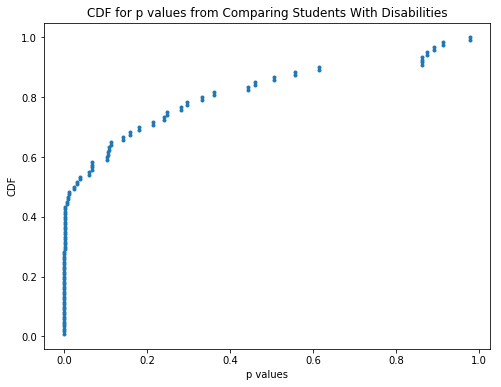

In [15]:
p_value, cdf = ecdf(school_dis_compare['p_value'])

plt.figure(figsize=(8,6))
plt.plot(p_value, cdf, marker='.', linestyle='none')
plt.xlabel('p values')
plt.ylabel('CDF')
plt.title('CDF for p values from Comparing Students With Disabilities')

In [18]:
school_sigdif_dis = school_dis_compare[school_dis_compare['p_value'] < 0.05]

print("Proportion of significantly different zip codes: {:.2f}".format(len(school_sigdif_dis)/len(school_dis_compare)))

Proportion of significantly different zip codes: 0.53


In [20]:
prop_public_higher_dis  = school_sigdif_dis['public_higher'].sum()/len(school_dis_compare)

print("Proportion of Zip Codes where Public Schools have significantly higher %'s of students with disabilities: {:.3f}".format(prop_public_higher_dis))

Proportion of Zip Codes where Public Schools have significantly higher %'s of students with disabilities: 0.433


In [21]:
print("Proportion amongst zip codes with significantly different schools where Public Schools have significantly higher %'s of students with disabilities: {:.3f}".format(school_sigdif_dis['public_higher'].sum()/len(school_sigdif_dis)))

Proportion amongst zip codes with significantly different schools where Public Schools have significantly higher %'s of students with disabilities: 0.812
